# Project - 2 `Boundry Layer Problem`


`Libraries`


In [1]:
import matplotlib.pyplot as plt
import numpy as np

`Grid Specifications`


In [2]:
Lx, Ly = 1.0, 0.1
Re = 1e4
U_inf = 1.0
nx, ny = 100, 100
nu = (U_inf * Lx) / Re
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
u = np.ones((nx, ny),dtype=float)  * U_inf
v = np.zeros((nx, ny), dtype=float)

`Plotting Functions`


In [3]:
def contourPlot(x,y,u, val):
    plt.figure(figsize=(8, 6))
    plt.contourf(x,y, u.T, levels=50, cmap='jet')
    plt.colorbar(label=val)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Contour Plot of {val}')
    plt.show()

In [4]:
def boundryLayerThikness(x, u):
    delta = np.zeros(nx)
    for i in range(nx):
        delta_idx = np.where(u[i, :] >= 0.99 * U_inf)[0]
        if len(delta_idx) > 0:
            delta[i] = y[delta_idx[0]]
        else:
            delta[i] = Ly
    plt.figure(figsize=(8, 6))
    plt.plot(x, delta, label='Numerical Solution')
    plt.plot(x, 4.91 * np.sqrt(nu * x / U_inf), label='Blasius Solution', linestyle='--')
    plt.xlabel('x(m)')
    plt.ylabel('Boundary Layer Thickness, δ(m)')
    plt.title('Boundary Layer Thickness vs. x')
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
def similarity_plot(u):
    F_prime = np.zeros((nx, ny))
    eta = np.zeros((nx, ny))

    for i in range(nx):
        for j in range(ny):
            if x[i] != 0:
                eta[i, j] = y[j] * np.sqrt(U_inf / (nu * x[i]))
            F_prime[i, j] = u[i, j] / U_inf

    plt.figure(figsize=(8, 6))
    for i in range(0, nx, nx // 5):
        plt.plot(eta[i, :], F_prime[i, :], label=f'x = {x[i]:.2f} m')
    plt.xlabel(r'η')
    plt.ylabel("F'(η)")
    plt.title("Normalized Velocity Profiles vs Similarity Variable (η)")
    plt.grid(True)
    plt.legend()
    plt.show()

`Solver Used`


In [6]:
def tdma_solver(a, b, c, d):
    n = len(b)
    
    # Forward elimination
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    # Back substitution
    x = np.zeros(n)
    x[-1] = d[-1] / b[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]
    
    return x

1. Euler Explicit scheme


In [7]:
def EulerExplicitScheme():

    dy = Ly / (ny - 1)
    dx = 0.5* (dy**2)/(2 *nu)

    # Boundary Conditions
    u[:, 0] = 0  # No-slip condition at the wall
    u[:, -1] = U_inf  # Inlet condition at the top edge
    v[:, 0] = 0  # No penetration at the wall (bottom)
    v[0, :] = 0  # No penetration at the leading edge
    for i in range(1, nx):
        un = u[i-1, :].copy()

        for j in range(1, ny-1):
            u[i, j] = un[j] + dx * (
                -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
                + nu * (un[j+1] - 2 * un[j] + un[j-1]) / dy**2
            )
            
            v[i, j] = v[i-1, j] - (dx / dy) * (u[i, j] - u[i-1, j])
            
    return u,v

In [8]:
u,v = EulerExplicitScheme()

C:\Users\Vardan\AppData\Local\Temp\ipykernel_2672\2888705568.py:16: RuntimeWarning: overflow encountered in scalar multiply
  -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
C:\Users\Vardan\AppData\Local\Temp\ipykernel_2672\2888705568.py:16: RuntimeWarning: invalid value encountered in scalar add
  -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
C:\Users\Vardan\AppData\Local\Temp\ipykernel_2672\2888705568.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
C:\Users\Vardan\AppData\Local\Temp\ipykernel_2672\2888705568.py:15: RuntimeWarning: invalid value encountered in scalar add
  u[i, j] = un[j] + dx * (


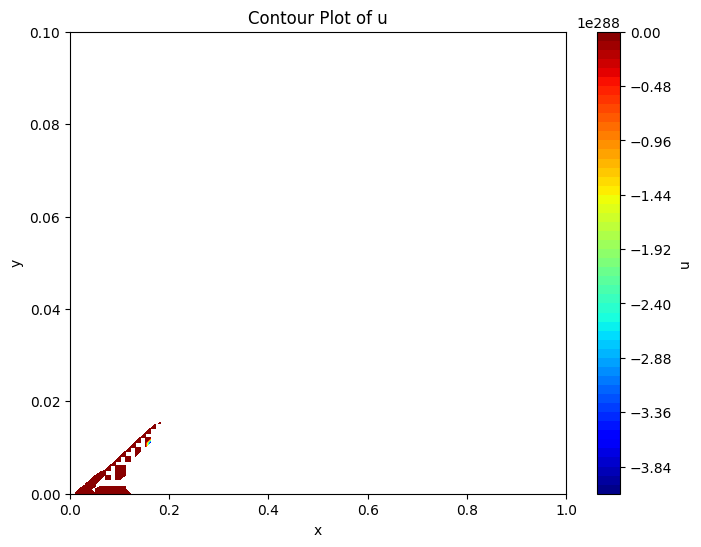

In [9]:
contourPlot(x,y,u , 'u')

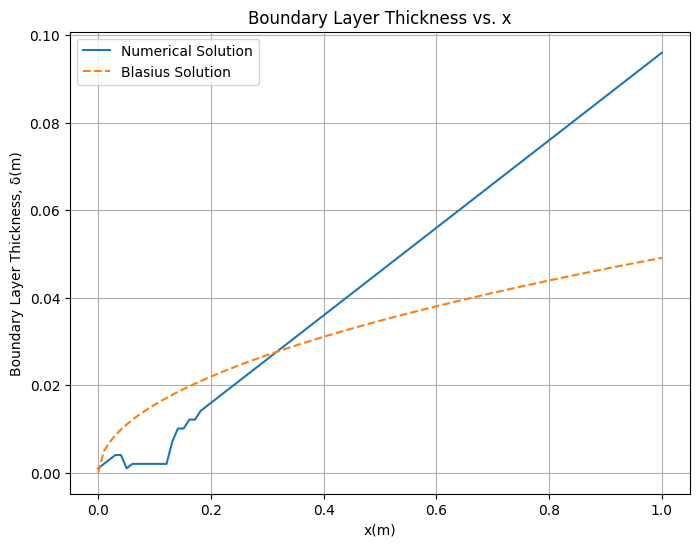

In [10]:
boundryLayerThikness(x,u)

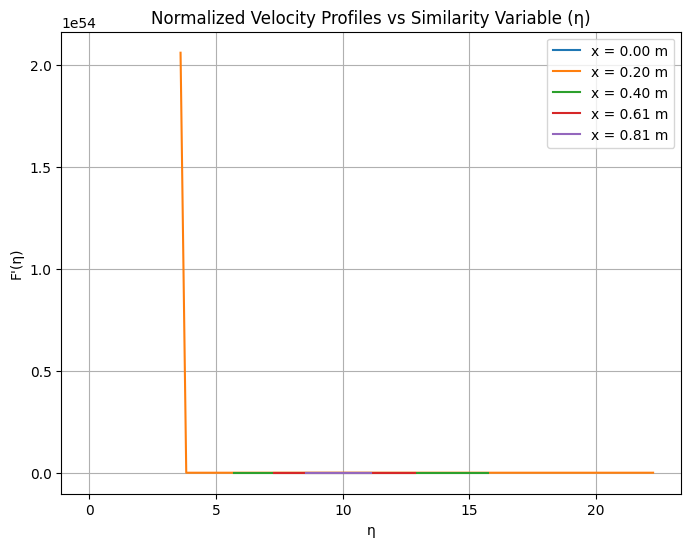

In [11]:
similarity_plot(u)

2.  Euler Implicit scheme


In [12]:
Lx, Ly = 10.0, 1.0
Re = 1e4
U_inf = 1.0
nx, ny = 200, 100
nu = (U_inf * Lx) / Re
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
u = np.ones((nx, ny),dtype=float) * U_inf
v = np.zeros((nx, ny), dtype=float)

In [13]:
def EulerImplicitScheme():
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)
    u[:, 0] = 0  # No-slip condition at the wall
    u[:, -1] = U_inf  # Inlet condition at the top edge
    v[:, 0] = 0  # No penetration at the wall (bottom)
    v[0, :] = 0  # No penetration at the leading edge


    for i in range(1, nx):
        u[i, :] = u[i-1, :]
        
        for _ in range(10000):  

            A_lower = np.zeros(ny-1)
            A_main = np.zeros(ny)
            A_upper = np.zeros(ny-1)
            b = np.zeros(ny)

            for j in range(1, ny-1):
                A_lower[j-1] = -nu/dy**2 + v[i,j]/(2*dy)
                A_main[j] = 2*nu/dy**2 + u[i,j]/dx
                A_upper[j] = -nu/dy**2 - v[i,j]/(2*dy)
                b[j] = u[i-1,j] * u[i,j] / dx
            
            # Boundary conditions
            A_main[0] = 1
            b[0] = 0
            A_main[-1] = 1
            b[-1] = U_inf


            u_new = tdma_solver(A_lower, A_main, A_upper, b)

            if np.linalg.norm(u_new - u[i, :]) < 1e-6:
                u[i, :] = u_new
                break
            u[i, :] = u_new

        for j in range(1, ny):
            v[i, j] = v[i, j-1] - dy/dx * (u[i, j] - u[i-1, j])
    
    return u, v

In [14]:
u, v = EulerImplicitScheme()

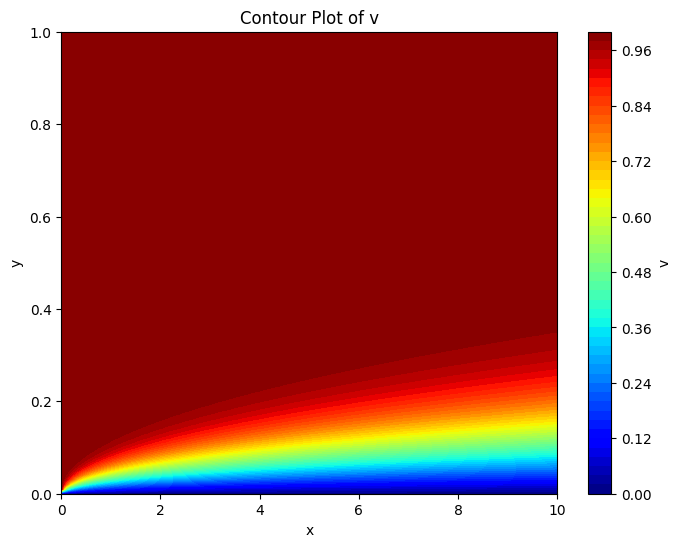

In [15]:
contourPlot(x,y,u,'v')

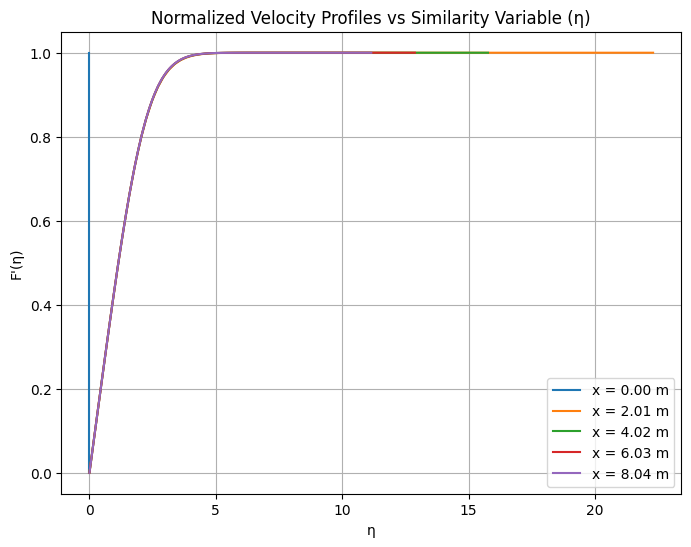

In [16]:
similarity_plot(u)

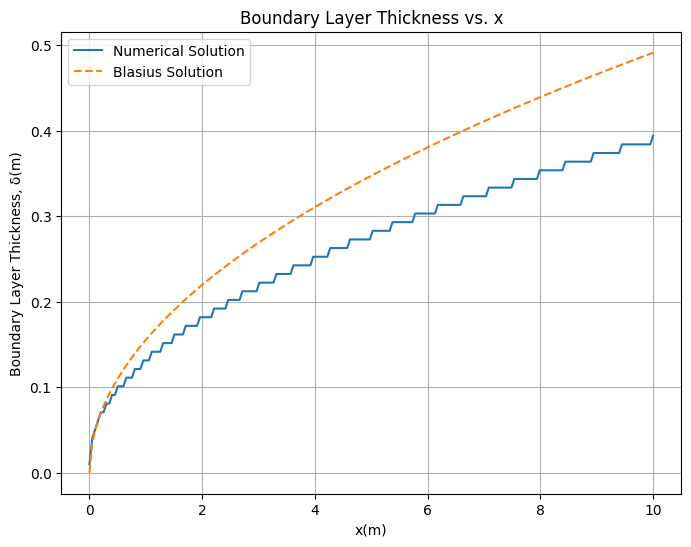

In [17]:
boundryLayerThikness(x,u)

3. Crank-Nicolson scheme


In [18]:
Lx, Ly = 10.0, 1.0
Re = 1e4
U_inf = 1.0
nx, ny = 200, 200
nu = (U_inf * Lx) / Re
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
u = np.ones((nx, ny),dtype=float) * U_inf
v = np.zeros((nx, ny), dtype=float)

In [19]:
dy = Ly / (ny - 1)
dx = Lx / (nx - 1)

In [20]:
def CrankNicolsonScheme():

    for i in range(1, nx):
        u[i, :] = u[i-1, :]
        
        for _ in range(10000):
            A_lower = np.zeros(ny-1)
            A_main = np.zeros(ny)
            A_upper = np.zeros(ny-1)
            b = np.zeros(ny)

            for j in range(1, ny-1):
                # Crank-Nicolson Coefficients
                A_lower[j-1] = -nu / (2 * dy**2) + v[i,j] / (4 * dy)
                A_main[j] = 1 / dx + nu / (dy**2)
                A_upper[j] = -nu / (2 * dy**2) - v[i,j] / (4 * dy)
                b[j] = u[i-1, j] / dx + (u[i, j+1] - 2 * u[i, j] + u[i, j-1]) * nu / (2 * dy**2)

            # Boundary conditions for tdma
            A_main[0] = 1  # Dirichlet boundary condition at bottom wall
            b[0] = 0       # No-slip condition
            A_main[-1] = 1 # Dirichlet boundary condition at top wall
            b[-1] = U_inf  # Inlet condition
            
            u_new = tdma_solver(A_lower, A_main, A_upper, b)
            
            # Check for convergence
            if np.linalg.norm(u_new - u[i, :]) < 1e-6:
                u[i, :] = u_new
                break
            u[i, :] = u_new

        for j in range(1, ny):
            v[i, j] = v[i, j-1] - dy/dx * (u[i, j] - u[i-1, j])

    return u, v

In [21]:
u,v = CrankNicolsonScheme()

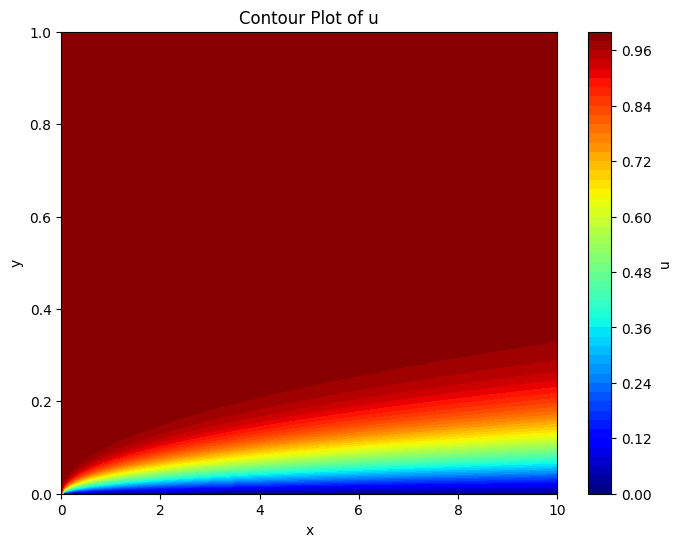

In [22]:
contourPlot(x,y,u,'u')

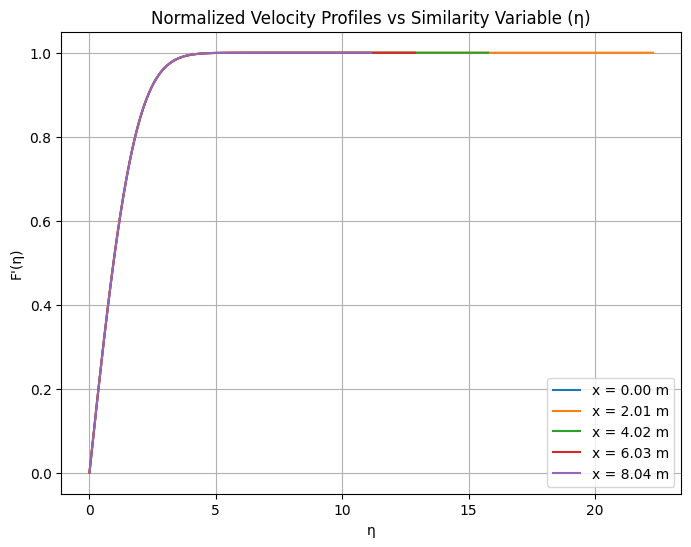

In [23]:
similarity_plot(u)

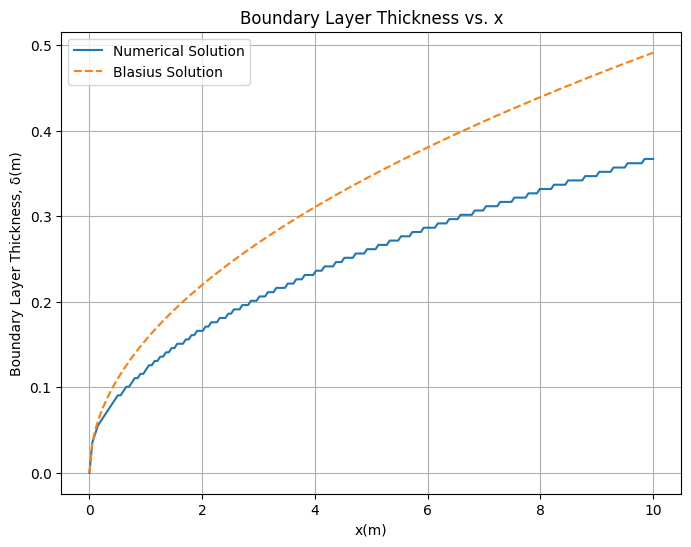

In [24]:
boundryLayerThikness(x,u)